# Wake Cylinder Problem: ANN vs PINN Comparison

This notebook compares a baseline ANN with a Physics-Informed Neural Network (PINN) for solving the wake cylinder problem.

In [17]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

interactive(children=(IntSlider(value=0, description='Frame', max=199), Output()), _dom_classes=('widget-inter…

<function __main__.update_plot(i)>

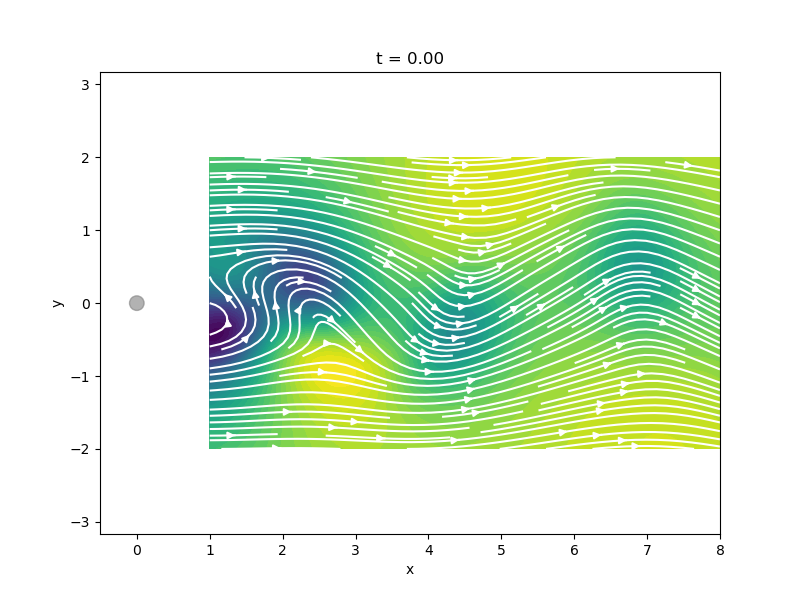

In [18]:
# Make sure you’re in a Jupyter cell (not a script)
%matplotlib widget

import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# === Load Data ===
data = scipy.io.loadmat('datasets/cylinder_nektar_wake.mat')
U_star = data['U_star']  # N x 2 x T
p_star = data['p_star']  # N x T
X_star = data['X_star']  # N x 2
t_star = data['t']       # T x 1

# === Reshape grid ===
x_unique = np.unique(X_star[:, 0])
y_unique = np.unique(X_star[:, 1])
Nx, Ny = len(x_unique), len(y_unique)
assert Nx * Ny == X_star.shape[0], "Unstructured grid."

x = X_star[:, 0].reshape(Ny, Nx)
y = X_star[:, 1].reshape(Ny, Nx)

# === Initialize figure once ===
fig, ax = plt.subplots(figsize=(8, 6))
contour = None
stream = None

# Define cylinder radius and center position
cylinder_radius = 0.1  # Adjust based on your data
cylinder_center = (0, 0)  # Assuming the cylinder is at the center (0, 0)

# === Function to update plot ===
def update_plot(i):
    global contour, stream
    ax.clear()  # Clear previous frame

    u = U_star[:, 0, i].reshape(Ny, Nx) # Velocity in x-direction
    v = U_star[:, 1, i].reshape(Ny, Nx) # Velocity in y-direction
    p = p_star[:, i].reshape(Ny, Nx) # Pressure

    # Plot the pressure contour
    contour = ax.contourf(x, y, p, levels=50, cmap='viridis')
    stream = ax.streamplot(x, y, u, v, color='white', density=1.5)

    # Add the cylinder shape (circle)
    circle = plt.Circle(cylinder_center, cylinder_radius, color='gray', alpha=0.6, label="Cylinder")
    ax.add_patch(circle)
    
    # Set labels and title
    ax.set_title(f't = {t_star[i, 0]:.2f}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.axis('equal')
    fig.canvas.draw_idle()

# === Create and display slider ===
slider = widgets.IntSlider(0, 0, U_star.shape[2] - 1, step=1, description='Frame')
widgets.interact(update_plot, i=slider)


In [19]:
U_star = data['U_star'] # N x 2 x T
P_star = data['p_star'] # N x T
t_star = data['t'] # T x 1
X_star = data['X_star'] # N x 2

N, T = X_star.shape[0], t_star.shape[0]

# Create coordinate grids
x_coords = np.repeat(X_star[:, 0:1], T, axis=1)  # Shape: [N, T]
y_coords = np.repeat(X_star[:, 1:2], T, axis=1)  # Shape: [N, T]
time_coords = np.repeat(t_star.T, N, axis=0)     # Shape: [N, T]

# Extract velocity components and pressure
u_vals = U_star[:, 0, :]  # Shape: [N, T]
v_vals = U_star[:, 1, :]  # Shape: [N, T]
p_vals = P_star           # Shape: [N, T]

# Flatten everything into NT x 1 arrays
x = x_coords.ravel()[:, None]
y = y_coords.ravel()[:, None]
t = time_coords.ravel()[:, None]

u = u_vals.ravel()[:, None]
v = v_vals.ravel()[:, None]
p = p_vals.ravel()[:, None]

train_samples = 5000
# Training Data    
idx = np.random.choice(N*T, train_samples, replace=False)
x_train = x[idx,:]
y_train = y[idx,:]
t_train = t[idx,:]
u_train = u[idx,:]
v_train = v[idx,:]



In [20]:
import torch
import torch.nn as nn
import numpy as np

class CylinderPINN(nn.Module):
    def __init__(self, hidden_size=20, num_layers=9):
        super().__init__()
        self.nu = 0.01  # kinematic viscosity
        
        # Neural network architecture
        layers = []
        layers.append(nn.Linear(3, hidden_size))  # Input layer: x, y, t
        layers.append(nn.Tanh())
        
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
            
        layers.append(nn.Linear(hidden_size, 2))  # Output layer: ψ (stream function), p (pressure)
        
        self.net = nn.Sequential(*layers)

    def forward(self, x, y, t):
        # Combine inputs
        inputs = torch.cat([x, y, t], dim=1)
        # Get stream function (ψ) and pressure (p)
        outputs = self.net(inputs)
        psi, p = outputs[:, 0:1], outputs[:, 1:2]
        
        # Calculate velocities and their derivatives
        u = torch.autograd.grad(psi, y, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
        v = -torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
        
        return u, v, p

    def compute_pde_residual(self, x, y, t):
        # Forward pass to get velocities and pressure
        u, v, p = self.forward(x, y, t)
        
        # Calculate all required derivatives
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
        
        v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
        v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]
        
        p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
        p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]
        
        # Navier-Stokes equations residuals
        f = u_t + u * u_x + v * u_y + p_x - self.nu * (u_xx + u_yy)
        g = v_t + u * v_x + v * v_y + p_y - self.nu * (v_xx + v_yy)
        
        return f, g

In [35]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import scipy.io
import numpy as np

def load_data(file_path, n_train=5000):
    data = scipy.io.loadmat(file_path)
    
    U_star = data['U_star']  # N x 2 x T
    P_star = data['p_star']  # N x T
    t_star = data['t']       # T x 1
    X_star = data['X_star']  # N x 2
    
    N, T = X_star.shape[0], t_star.shape[0]
    
    # Reshape data
    XX = np.tile(X_star[:, 0:1], (1, T))
    YY = np.tile(X_star[:, 1:2], (1, T))
    TT = np.tile(t_star, (1, N)).T
    
    UU = U_star[:, 0, :]
    VV = U_star[:, 1, :]
    
    # Flatten arrays
    x = XX.flatten()[:, None]
    y = YY.flatten()[:, None]
    t = TT.flatten()[:, None]
    u = UU.flatten()[:, None]
    v = VV.flatten()[:, None]
    
    # Sample training data
    idx = np.random.choice(N * T, n_train, replace=False)
    
    return (torch.FloatTensor(x[idx]), 
            torch.FloatTensor(y[idx]), 
            torch.FloatTensor(t[idx]),
            torch.FloatTensor(u[idx]), 
            torch.FloatTensor(v[idx]))

def train_pinn(model, data, epochs=1000, lr=1.0):
    x, y, t, u_true, v_true = data
    x.requires_grad_(True)
    y.requires_grad_(True)
    t.requires_grad_(True)
    
    # Use L-BFGS optimizer
    optimizer = torch.optim.LBFGS(model.parameters(), 
                                  lr=lr,
                                  max_iter=5000,
                                  max_eval=5000,
                                  history_size=50,
                                  tolerance_grad=1e-5,
                                  tolerance_change=1.0 * np.finfo(float).eps,
                                  line_search_fn="strong_wolfe")
    
    mse_loss = nn.MSELoss()
    lbfgs_epoch = {'count': 0}
    # Define a closure function that optimizer will call
    def closure():
        optimizer.zero_grad()
        lbfgs_epoch ['count'] += 1
        # Data loss
        u_pred, v_pred, _ = model(x, y, t)
        data_loss = mse_loss(u_pred, u_true) + mse_loss(v_pred, v_true)
        
        # Physics loss
        f, g = model.compute_pde_residual(x, y, t)
        physics_loss = mse_loss(f, torch.zeros_like(f)) + mse_loss(g, torch.zeros_like(g))
        
        # Total loss
        loss = data_loss + physics_loss
        
        loss.backward()
        
        # Print current loss
        print(f'\rInner Epoch: {lbfgs_epoch["count"]} | Loss: {loss.item():.4f}, Data Loss: {data_loss.item():.4f}, Physics Loss: {physics_loss.item():.4f}')
        
        return loss
    
    # Training loop
    print("Starting L-BFGS optimization...")
    for i in range(epochs):
        print(f"\nEpoch {i+1}/{epochs}")
        optimizer.step(closure)
    
    return model


# Load data
data = load_data('datasets/cylinder_nektar_wake.mat')

# Initialize model
model = CylinderPINN()

# Train model
trained_model = train_pinn(model, data, epochs=1)

# Save model
torch.save(trained_model.state_dict(), 'cylinder_pinn.pt')

Starting L-BFGS optimization...

Epoch 1/1
Inner Epoch: 1 | Loss: 0.9004, Data Loss: 0.9004, Physics Loss: 0.0000
Inner Epoch: 2 | Loss: 0.9002, Data Loss: 0.9002, Physics Loss: 0.0000
Inner Epoch: 3 | Loss: 0.8994, Data Loss: 0.8994, Physics Loss: 0.0000
Inner Epoch: 4 | Loss: 0.8994, Data Loss: 0.8994, Physics Loss: 0.0000
Inner Epoch: 5 | Loss: 0.8931, Data Loss: 0.8931, Physics Loss: 0.0000
Inner Epoch: 6 | Loss: 0.8888, Data Loss: 0.8888, Physics Loss: 0.0000


KeyboardInterrupt: 

In [ ]:
import ipywidgets as widgets
from IPython.display import display

def create_visualization_grid(X_star):
    x_unique = np.unique(X_star[:, 0])
    y_unique = np.unique(X_star[:, 1])
    
    x_mesh, y_mesh = np.meshgrid(x_unique, y_unique)
    return x_mesh, y_mesh


def visualize_flow_interactive(model, X_star, t_values, normalizer=None):
    model.eval()
    
    # Create visualization grid
    x_unique = np.unique(X_star[:, 0])
    y_unique = np.unique(X_star[:, 1])
    x_mesh, y_mesh = np.meshgrid(x_unique, y_unique)
    
    # Create tensors with gradients enabled
    x_flat = x_mesh.flatten()[:, None]
    y_flat = y_mesh.flatten()[:, None]
    
    # Convert to tensors
    x = torch.FloatTensor(x_flat).requires_grad_(True)
    y = torch.FloatTensor(y_flat).requires_grad_(True)
    
    # Create figure
    fig = plt.figure(figsize=(10, 8))
    ax = plt.gca()
    
    def update_plot(time_idx):
        ax.clear()
        
        # Create time tensor with gradients enabled
        t_value = t_values[time_idx, 0]
        t = torch.full_like(x, t_value).requires_grad_(True)
        
        # Normalize inputs if normalizer is provided
        if normalizer:
            x_norm, y_norm, t_norm = normalizer.normalize(x, y, t)
            # Compute model predictions with normalized inputs
            u_norm, v_norm, p = model(x_norm, y_norm, t_norm)
            # Denormalize outputs
            u, v = normalizer.denormalize_uv(u_norm, v_norm)
        else:
            # Direct prediction without normalization
            u, v, p = model(x, y, t)
        
        # Detach tensors for plotting
        p_grid = p.detach().numpy().reshape(x_mesh.shape)
        u_grid = u.detach().numpy().reshape(x_mesh.shape)
        v_grid = v.detach().numpy().reshape(x_mesh.shape)
        
        # Plot pressure contour
        contour = ax.contourf(x_mesh, y_mesh, p_grid, levels=30, cmap='viridis')
        
        # Add streamlines
        ax.streamplot(x_mesh, y_mesh, u_grid, v_grid, color='white', density=1.5)
        
        # Add cylinder
        circle = plt.Circle((0, 0), cylinder_radius, color='gray', alpha=0.6)
        ax.add_patch(circle)
        
        # Set labels and title
        ax.set_title(f't = {t_value:.2f}')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_aspect('equal')
        fig.colorbar(contour, ax=ax, label='Pressure')
        
        # Draw canvas
        fig.canvas.draw()
    
    # Create time slider
    time_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(t_values)-1,
        step=1,
        description='Time:',
        continuous_update=False
    )
    
    # Link slider to update function
    widgets.interact(update_plot, time_idx=time_slider)
    
    # Initial plot
    update_plot(0)
    
    plt.show()
    
    return fig, ax

# Usage example:
# fig, ax = visualize_flow_interactive(model, X_star, t_star, normalizer=model.normalizer)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Time:', max=199), Output()), _d…

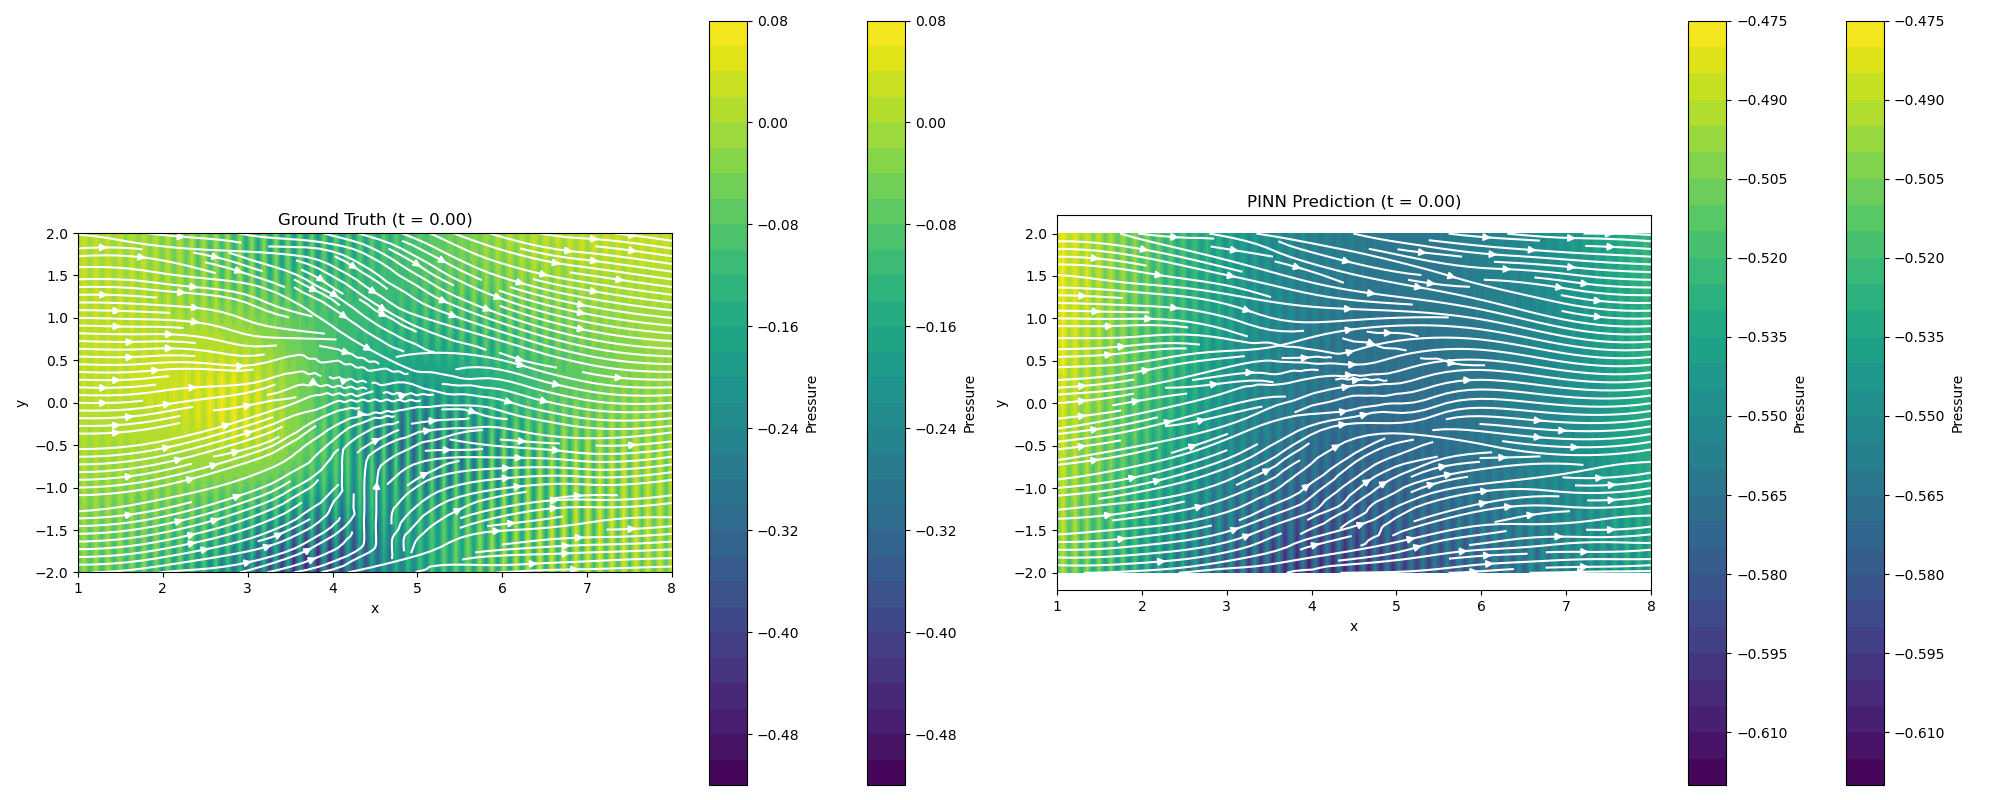

In [ ]:
def visualize_comparison_interactive(model, X_star, U_star, p_star, t_star):
    model.eval()
    
    # Create visualization grid with correct dimensions
    x_unique = np.unique(X_star[:, 0])
    y_unique = np.unique(X_star[:, 1])
    Nx, Ny = len(x_unique), len(y_unique)
    x_mesh, y_mesh = np.meshgrid(x_unique, y_unique)
    
    # Create tensors with gradients enabled
    x = torch.FloatTensor(x_mesh.flatten()[:, None]).requires_grad_(True)
    y = torch.FloatTensor(y_mesh.flatten()[:, None]).requires_grad_(True)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    def update_plot(time_idx):
        ax1.clear()
        ax2.clear()
        
        # Ground Truth Data - Reshape with correct dimensions
        u_true = U_star[:, 0, time_idx].reshape(Nx, Ny).T
        v_true = U_star[:, 1, time_idx].reshape(Nx, Ny).T
        p_true = p_star[:, time_idx].reshape(Nx, Ny).T
        
        # PINN Predictions
        t = torch.full_like(x, t_star[time_idx, 0]).requires_grad_(True)
        u_pred, v_pred, p_pred = model(x, y, t)
        u_pred = u_pred.detach().numpy().reshape(Nx, Ny).T
        v_pred = v_pred.detach().numpy().reshape(Nx, Ny).T
        p_pred = p_pred.detach().numpy().reshape(Nx, Ny).T
        
        # Plot Ground Truth
        contour1 = ax1.contourf(x_mesh, y_mesh, p_true, levels=30, cmap='viridis')
        ax1.streamplot(x_mesh, y_mesh, u_true, v_true, color='white', density=1.5)
        circle1 = plt.Circle((0, 0), 0.1, color='gray', alpha=0.6)
        ax1.add_patch(circle1)
        ax1.set_title(f'Ground Truth (t = {t_star[time_idx, 0]:.2f})')
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_aspect('equal')
        
        # Plot PINN Predictions
        contour2 = ax2.contourf(x_mesh, y_mesh, p_pred, levels=30, cmap='viridis')
        ax2.streamplot(x_mesh, y_mesh, u_pred, v_pred, color='white', density=1.5)
        circle2 = plt.Circle((0, 0), 0.1, color='gray', alpha=0.6)
        ax2.add_patch(circle2)
        ax2.set_title(f'PINN Prediction (t = {t_star[time_idx, 0]:.2f})')
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
        ax2.set_aspect('equal')
        
        # Add colorbars
        plt.colorbar(contour1, ax=ax1, label='Pressure')
        plt.colorbar(contour2, ax=ax2, label='Pressure')
        
        # Adjust layout
        plt.tight_layout()
        fig.canvas.draw()
    
    # Create time slider
    time_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(t_star)-1,
        step=1,
        description='Time:',
        continuous_update=False
    )
    
    # Link slider to update function
    widgets.interact(update_plot, time_idx=time_slider)
    
    # Initial plot
    update_plot(0)
    
    plt.show()
    
    return fig, (ax1, ax2)
# Cell 1: Enable widget backend
%matplotlib widget

# Cell 2: Create visualization
fig, (ax1, ax2) = visualize_comparison_interactive(model, X_star, U_star, p_star, t_star)